In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
from zipfile import ZipFile

zip_files = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/PPEs.v7-raw-images_ommittedsuitclasses.voc.zip"

with ZipFile(zip_files, 'r') as zip:
    zip.printdir()

    # extract files
    print('Extracting all the files now...')
    zip.extractall('/content/sample_data')

Streaming output truncated to the last 5000 lines.
valid/frame1246_jpg.rf.3c6218d5bf78c820d64cd52c68a19edc.xml 2022-10-30 16:22:30         1380
valid/frame1247_jpg.rf.abcc2371cf8f19d76317b95f2678d1da.jpg 2022-10-30 16:22:24       729085
valid/frame1247_jpg.rf.abcc2371cf8f19d76317b95f2678d1da.xml 2022-10-30 16:22:30         1380
valid/frame1248_jpg.rf.35e77cc4c884e99a1370f45031863970.jpg 2022-10-30 16:22:24       728875
valid/frame1248_jpg.rf.35e77cc4c884e99a1370f45031863970.xml 2022-10-30 16:22:30         1380
valid/frame1249_jpg.rf.61e6471db6c2f89b8bd5a47a54e90702.jpg 2022-10-30 16:22:26       728661
valid/frame1249_jpg.rf.61e6471db6c2f89b8bd5a47a54e90702.xml 2022-10-30 16:22:30         1380
valid/frame124_jpg.rf.3eb586c6172a16a5fbe0d90d6c1177b4.jpg 2022-10-30 16:22:24       339216
valid/frame124_jpg.rf.3eb586c6172a16a5fbe0d90d6c1177b4.xml 2022-10-30 16:22:30          868
valid/frame125--2-_jpg.rf.37a8fc900451a55831ee66adbcea8eaf.jpg 2022-10-30 16:22:24       716633
valid/frame125--2-

Installing and importing dependencies

In [22]:
pip install ultralyticsplus==0.0.24 ultralytics==8.0.23

EDA

Melakukan explorasi terhadap dataset.

In [23]:
import glob
import os
from pathlib import Path
import random
import math
import yaml

import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import shutil
from tqdm import tqdm

from IPython.display import HTML, display, Image
from base64 import b64encode
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image

In [24]:
class_map = {0: 'glove', 1: 'goggles', 2: 'helmet', 3: 'mask', 4: 'no_glove', 5: 'no_goggles', 6: 'no_helmet', 7: 'no_mask', 8: 'no_shoes', 9: 'shoes'}

In [25]:
classes = ['glove', 'goggles', 'helmet', 'mask', 'no_glove', 'no_goggles', 'no_helmet', 'no_mask', 'no_shoes', 'shoes']


In [26]:
dataset_root = '/content/sample_data'
for subset_folder in ['train', 'valid', 'test']:
    subset_images = glob.glob(os.path.join(dataset_root, subset_folder, '*.jpg'))
    print(f"Number of {subset_folder} images:", len(subset_images))

Number of train images: 6473
Number of valid images: 3570
Number of test images: 1935


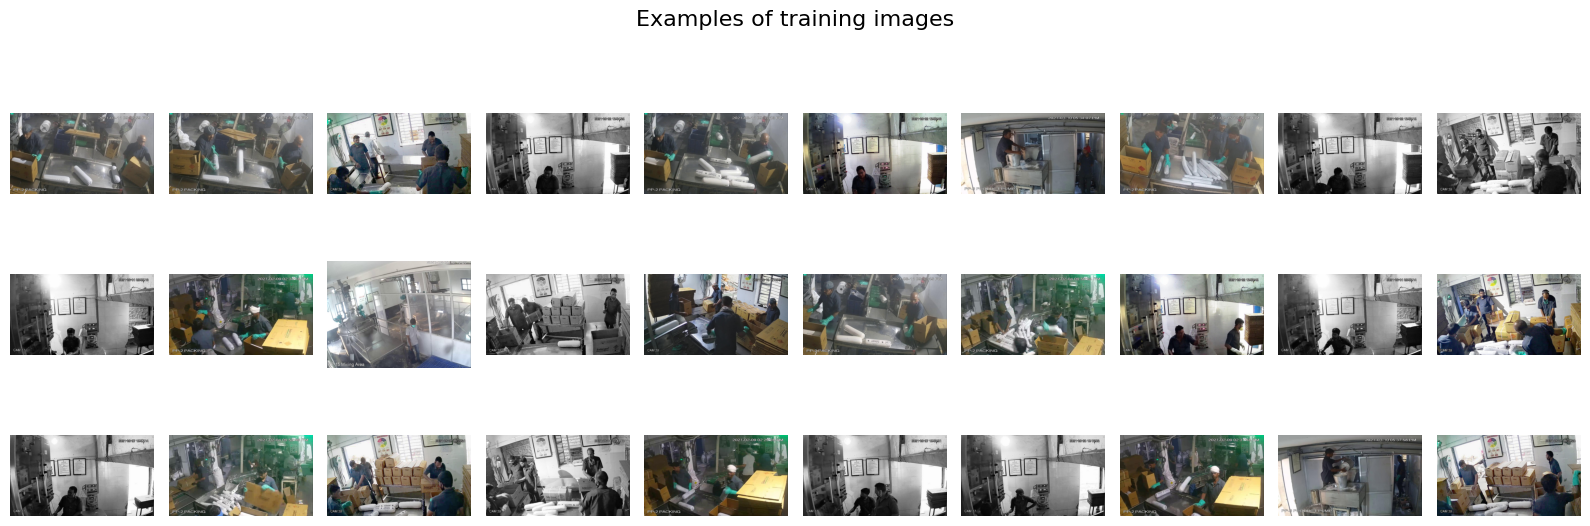

In [27]:
test_imgs_with_pred = glob.glob(os.path.join(dataset_root, 'train', '*.jpg'))

fig, axes = plt.subplots(3, 10, figsize=(16,6))
fig.suptitle('Examples of training images', fontsize=16)

# Random 15 image
selected_images = random.sample(test_imgs_with_pred, 30)
for i, ax in enumerate(axes.flatten()):
    image = cv2.imread(selected_images[i])
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [28]:
classes_dict = {}
for subset_folder in ['train', 'valid', 'test']:
    label_folder = glob.glob(os.path.join(dataset_root, subset_folder, '*.xml'))
    cl1 = []
    for anno_file in label_folder:
            tree = ET.parse(anno_file)
            root = tree.getroot()

            for obj in root.findall('object'):
                # Extract  class label
                cl = obj.find('name').text
                # Append class label to list
                cl1.append(cl)

    class_counts = {label: cl1.count(label) for label in set(cl1)}
    classes_dict[subset_folder] = class_counts

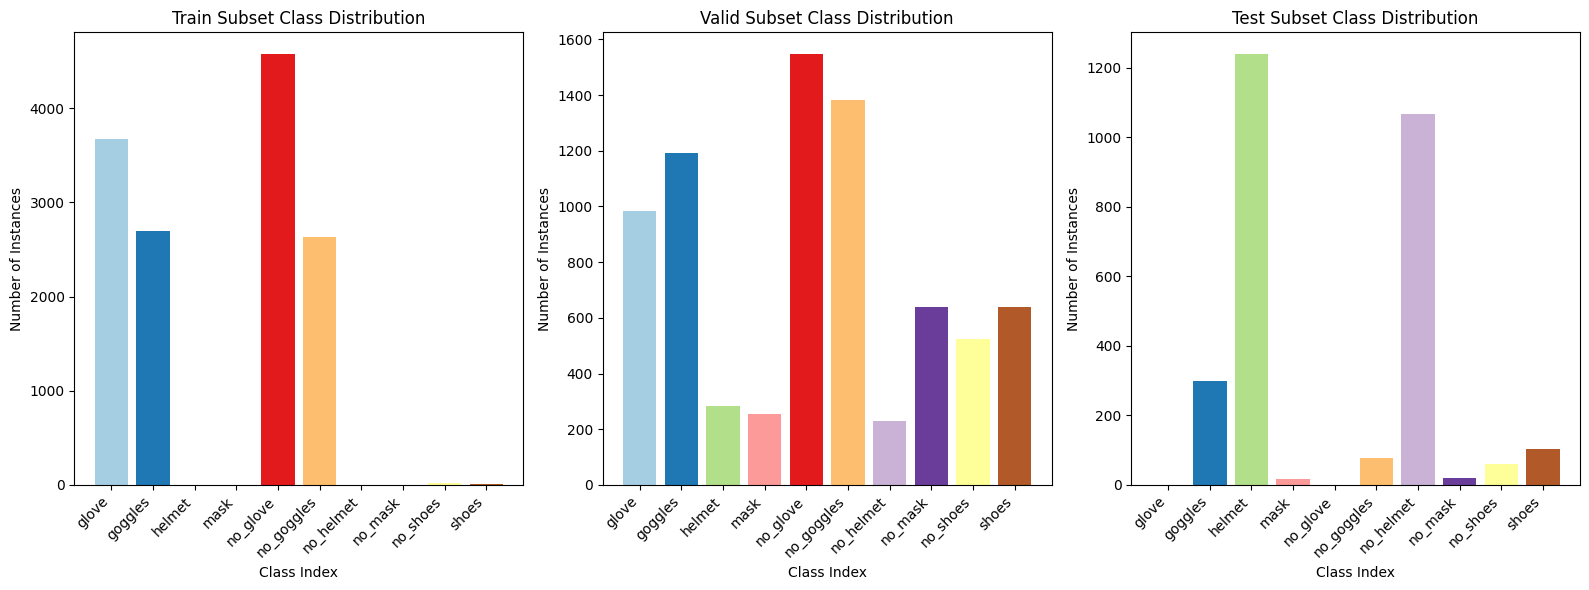

In [29]:
fig, axes = plt.subplots(1, len(classes_dict), figsize=(16, 6))

# Create colormap
cmap = plt.get_cmap('Paired')
colors = cmap(np.linspace(0, 1, len(class_map)))

for i, (subset_name, class_counts) in enumerate(classes_dict.items()):
    sorted_class_counts = {class_index: class_counts.get(class_map[class_index], 0) for class_index in range(len(class_map))}

    class_indices = list(sorted_class_counts.keys())
    counts = list(sorted_class_counts.values())

    # Plot bar chart
    axes[i].bar(class_indices, counts, color=colors)
    axes[i].set_title(f'{subset_name.capitalize()} Subset Class Distribution')
    axes[i].set_xlabel('Class Index')
    axes[i].set_ylabel('Number of Instances')
    axes[i].set_xticks(range(len(class_map)))
    axes[i].set_xticklabels([class_map[idx] for idx in range(len(class_map))], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Memindahkan annotation file ke folder annotation

In [ ]:
import shutil

def move_xml_files(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    image_folder = os.path.join(destination_folder, "image")
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)

    files = os.listdir(source_folder)

    for file in files:
        if file.endswith(".xml"):
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join(destination_folder, file)
            shutil.move(source_file, destination_file)
            print(f"{file} dipindahkan ke {destination_folder}")
        elif file.endswith(".jpg"):
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join(image_folder, file)
            shutil.move(source_file, destination_file)
            print(f"{file} dipindahkan ke {image_folder}")

source_train_xml = "/content/sample_data/train"
destination_train_xml = "/content/sample_data/train/destination_folder"
source_test_xml = "/content/sample_data/test"
destination_test_xml = "/content/sample_data/test/destination_folder"
source_valid_xml = "/content/sample_data/valid"
destination_valid_xml = "/content/sample_data/valid/destination_folder"

move_xml_files(source_train_xml, destination_train_xml)
move_xml_files(source_test_xml, destination_test_xml)
move_xml_files(source_valid_xml, destination_valid_xml)

Streaming output truncated to the last 5000 lines.
NX_img_27_jpg.rf.371de5fe9b22f5e0448864c13b8a5de7.xml dipindahkan ke /content/sample_data/test/destination_folder
helmet999542_jpg.rf.863050732f8ae18316929dd44bea517a.xml dipindahkan ke /content/sample_data/test/destination_folder
p11357_jpg.rf.77296cf0cab50469960f4e15a4e6b7bb.xml dipindahkan ke /content/sample_data/test/destination_folder
p11395_jpg.rf.94feb2573d4c34d74f17acaebf9dfffd.xml dipindahkan ke /content/sample_data/test/destination_folder
MX_img_28_jpg.rf.05e7c6c5f87cfdff8b52ea4e4c362acd.xml dipindahkan ke /content/sample_data/test/destination_folder
N5h_img_36_jpg.rf.67efb78d0b876475098b046de8c746b6.xml dipindahkan ke /content/sample_data/test/destination_folder
MX_img_182_jpg.rf.c5439c51eb59e50c2eca7ca56da4cdcb.xml dipindahkan ke /content/sample_data/test/destination_folder
frame115--2-_jpg.rf.75e2bd323a1bfa8977a5dd88f50ecbb4.xml dipindahkan ke /content/sample_data/test/destination_folder
frame1_jpg.rf.5ac2935c31a80b7b6a936

Data Preparation

In [30]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

fatal: destination path 'ultralytics' already exists and is not an empty directory.


In [5]:
from zipfile import ZipFile

zip_files = "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/PPEs.v7-raw-images_ommittedsuitclasses.yolov8.zip"

with ZipFile(zip_files, 'r') as zip:
    zip.printdir()

    print('Extracting all the files now...')
    zip.extractall('/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset')

Streaming output truncated to the last 5000 lines.
valid/images/helmet9991075_jpg.rf.77edb0cd5bbd0d079a153f9385a17dac.jpg 2023-01-29 09:14:14        95839
valid/images/helmet9991079_jpg.rf.16e443fed3f31ef8f3e6991219d610a1.jpg 2023-01-29 09:14:14        94837
valid/images/helmet9991093_jpg.rf.14e970b4b21e25838d917ee2b1a64c4a.jpg 2023-01-29 09:14:14        95529
valid/images/helmet9991095_jpg.rf.3a3b06193c0159fbd4a11253dfc873ac.jpg 2023-01-29 09:14:10        95433
valid/images/helmet9991100_jpg.rf.c492afce18ce5b8b5f62ebf4bc16b79d.jpg 2023-01-29 09:14:12        93742
valid/images/helmet9991104_jpg.rf.cff132b6b5a5c78b70c45604e7ef255f.jpg 2023-01-29 09:14:12        93492
valid/images/helmet9991112_jpg.rf.b444a9f4190098352685f41e541328a1.jpg 2023-01-29 09:14:10        99524
valid/images/helmet9991118_jpg.rf.b3b62b842c123a28cd3eccf492f5fa2e.jpg 2023-01-29 09:14:10        95929
valid/images/helmet9991120_jpg.rf.d2454862b3e46136714ad09a2a0a64e9.jpg 2023-01-29 09:14:12        93703
valid/images/

In [31]:
import yaml

# configuration
config = {
   "train": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/train/images",
   "val": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/valid/images",
   "test": "/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/test/images",
   "nc": 10,
   "names": ['glove', 'goggles', 'helmet', 'mask', 'no_glove', 'no_goggles', 'no_helmet', 'no_mask', 'no_shoes', 'shoes']
}
with open("/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/data2.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

Training data dengan yolo

In [ ]:
!yolo task=detect mode=train data=/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/data2.yaml model=yolov8s.pt epochs=10 lr0=0.01

100% 21.5M/21.5M [00:00<00:00, 142MB/s] 
Ultralytics YOLOv8.0.23 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Sistem_Pengenalan_Pelindung/dataset/data2.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, op